<a href="https://colab.research.google.com/github/Abhinavl3v3l/EVA3/blob/master/Assignment_6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout,Concatenate,Conv2D
from keras import Input, Model
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import keras

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


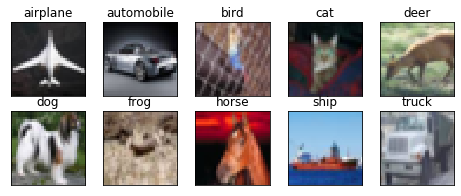

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

Assignment 6
1. Run this network.  (Links to an external site.) After training the network, whatever accuracy you get is your base accuracy. Epochs = 100
2. Fix the network above:
- remove dense
- add layers required to reach RF
- fix kernel scaleup and down (1x1)
- see if all dropouts are properly placed
- follow the guidelines we discussed in the class (
- Get accuracy more than the base accuracy in less number 100 epochs. Hint, you might want to use "border_mode='same',"
- Save File as Assignment 6A
3. Rewrite it again using these convolutions in the order given below:
- Normal Convolution
- Spatially Separable Convolution  (Conv2d(x, (3,1)) followed by Conv2D(x,(3,1))
- Depthwise Separable Convolution
- Grouped Convolution (use 3x3, 5x5 only)
- Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2) 
- You must use all of the 5 above at least once
- Train this new model for 50 epochs. 
- Save File as Assignment 6B
>Total Score of 600. 400 for Code (300+100), and 200 for documentation (100+100)
Upload the github folder link which has both the files. 

In [7]:
model = Sequential()
#Normal Convolution 
model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(32, 32, 3)))# 32
model.add(Activation('relu'))
model.add(BatchNormalization())

################################################################################
# Spatially Separable Convolution (Conv2d(x, (3,1)) followed by Conv2D(x,(3,1))
model.add(Convolution2D(64, 3, 1))#  30 x 32
model.add(Convolution2D(64, 1, 3))#  30 x 30
model.add(Activation('relu'))
model.add(BatchNormalization())
################################################################################

model.add(Convolution2D(10, 1, 1, activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) #15
model.add(Dropout(0.1))

################################################################################
# Depthwise Separable Convolution
model.add(SeparableConv2D(96, 3, 3))   # 13
model.add(Activation('relu')) 

################################################################################
# Group Convolution of 3x3 and 5x5
nb_filters = 96
kernel_size= {}
kernel_size[0]= [3,3]
kernel_size[1]= [5,5]
# kernel_size[2]= [5,5]
input_shape=(13, 13, 96)

inp = Input(shape=input_shape)
convs = []
for k_no in range(len(kernel_size)):
    conv = Conv2D(nb_filters,( kernel_size[k_no][0], kernel_size[k_no][1]),activation='relu',padding='same',input_shape=input_shape)(inp)
    convs.append(conv)

if len(kernel_size) > 1:
    out = Concatenate()(convs)
else:
   out = convs[0]
concat_model = Model(input=inp, output=out)

# add to sequential model
model.add(concat_model) #13
model.add(BatchNormalization())

################################################################################
# Group Convolution of 3x3 and 3x3 with dialation 1 and 2 resp
nb_filters = 192
kernel_size= {}
kernel_size[0]= [3,3]
kernel_size[1]= [3,3]
input_shape=(11, 11, 192)
dilation_val = [1,2]
inp = Input(shape=input_shape)
convs = []
for k_no in range(len(kernel_size)):
    conv = Conv2D(nb_filters, (3,3),padding='same',activation='relu',input_shape=input_shape,dilation_rate= dilation_val[k_no])(inp)
    convs.append(conv)

if len(kernel_size) > 1:
    out = Concatenate()(convs)
else:
    out = convs[0]

concat_model = Model(input=inp, output=out)

# add to sequential model
model.add(concat_model) #11
model.add(BatchNormalization())
model.add(Dropout(0.1))
################################################################################

model.add(SeparableConv2D(256, 3, 3))  #9
model.add(Activation('relu'))
model.add(BatchNormalization())

################################################################################

model.add(Convolution2D(10, 1, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5
model.add(Dropout(0.1))
################################################################################

model.add(SeparableConv2D(256, 3, 3)) #3
model.add(Activation('relu'))
model.add(BatchNormalization())

################################################################################

model.add(Convolution2D(10, 3))
model.add(Flatten())
model.add(Activation('softmax'))


# Compile the model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr): return round(0.008 * 1/(1 + 0.319 * epoch), 10)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.008), metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 1))`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 3))`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1), activation="relu")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Update

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 32, 64)        9280      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 64)        12352     
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 64)       

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  del sys.path[0]




Epoch 1/50
390/390 [==============================] - 36s 93ms/step - loss: 2.0323 - acc: 0.3164 - val_loss: 3.0503 - val_acc: 0.1615
Epoch 2/50
390/390 [==============================] - 29s 73ms/step - loss: 1.5158 - acc: 0.4652 - val_loss: 1.7132 - val_acc: 0.3826
Epoch 3/50
390/390 [==============================] - 29s 74ms/step - loss: 1.2183 - acc: 0.5620 - val_loss: 2.3963 - val_acc: 0.4052
Epoch 4/50
390/390 [==============================] - 29s 75ms/step - loss: 1.0823 - acc: 0.6124 - val_loss: 1.2129 - val_acc: 0.5931
Epoch 5/50
390/390 [==============================] - 29s 75ms/step - loss: 0.9933 - acc: 0.6490 - val_loss: 1.2437 - val_acc: 0.5874
Epoch 6/50
390/390 [==============================] - 30s 76ms/step - loss: 0.9157 - acc: 0.6767 - val_loss: 1.0866 - val_acc: 0.6448
Epoch 7/50
390/390 [==============================] - 30s 76ms/step - loss: 0.8474 - acc: 0.7010 - val_loss: 1.3093 - val_acc: 0.5747
Epoch 8/50
390/390 [==============================] - 30s 76

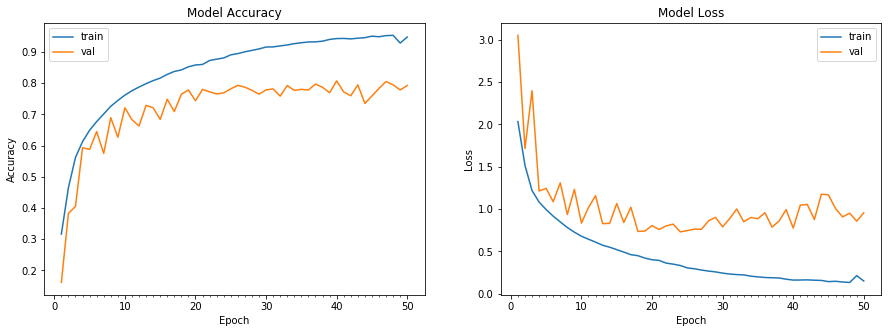

Accuracy on test data is: 79.21


In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)



# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))